In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read json
with open('/home/arpe/FormaMentis/hidden-swingers-personal/data/tweets_vips_annotated.json') as f:
    propaganda_tweets = json.load(f)

In [3]:
vips = pd.read_csv("/home/arpe/FormaMentis/twitter_representatives_handles_final.csv")

In [4]:
# create dataframe with tweet_id, created_at, author_id, Party, list of annotations
tweets = []
for tweet in propaganda_tweets:
    tweet_id = tweet
    created_at = propaganda_tweets[tweet]['created_at']
    author_id = propaganda_tweets[tweet]['author_id']
    Party = vips[vips['ids'] == author_id]['Party'].values[0]
    if "annotations" not in propaganda_tweets[tweet]:
        continue
    annotations = [sub["label"] for sub in propaganda_tweets[tweet]['annotations']]
    tweets.append([tweet_id, created_at, author_id, Party, annotations])

df = pd.DataFrame(tweets, columns=['tweet_id', 'created_at', 'author_id', 'Party', 'annotations'])
df

,tweet_id,created_at,author_id,Party,annotations
0,1544421129795821570,2022-07-05,1047059160,Fratelli d'Italia,[Slogans]
1,1544410254343081990,2022-07-05,130537001,Fratelli d'Italia,"[Conversation_Killer, Questioning_the_Reputati..."
2,1544407020148858881,2022-07-05,61160450,Lega,[Slogans]
3,1544406008746987521,2022-07-05,2416067982,Azione - Italia Viva,"[Doubt, Doubt, Doubt]"
4,1544404370921558016,2022-07-05,2416067982,Azione - Italia Viva,"[Appeal_to_Values, Appeal_to_Values, Doubt, Do..."
...,...,...,...,...,...
11844,1574496046524293120,2022-09-26,964460408,Partito Democratico,[Doubt]
11845,1574498265046732800,2022-09-26,964460408,Partito Democratico,"[Appeal_to_Values, Appeal_to_Values]"
11846,1574498293140406290,2022-09-26,337767301,Lega,"[Appeal_to_Hypocrisy, Doubt, Doubt, Doubt, Doubt]"
11847,1574512794984030208,2022-09-26,214485357,Partito Democratico,[Doubt]


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(-20.0, 0, '2022-10-01'),
  Text(0.0, 0, '2022-07-01'),
  Text(20.0, 0, '2022-07-21'),
  Text(40.0, 0, '2022-08-10'),
  Text(60.0, 0, '2022-08-30'),
  Text(80.0, 0, '2022-09-19'),
  Text(100.0, 0, '2022-10-09'),
  Text(120.0, 0, '')])

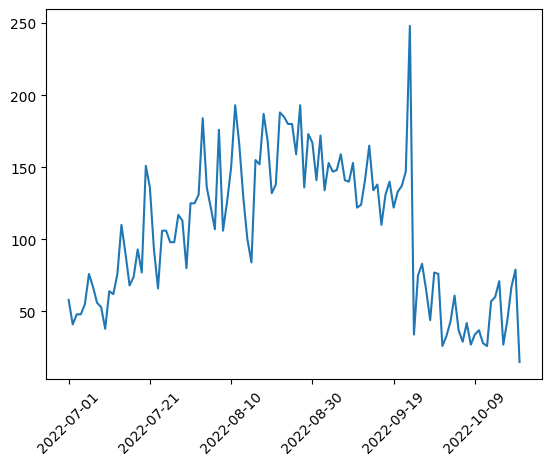

In [5]:
# count number of tweets by day
df["created_at"].value_counts().sort_index().plot()

# xticks rotation
plt.xticks(rotation=45)

<Axes: >

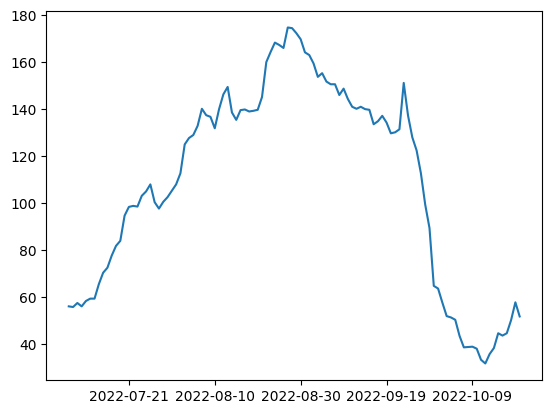

In [6]:
# rolling average of tweets by day
df["created_at"].value_counts().sort_index().rolling(window=7).mean().plot()


In [7]:
start_before = '2022-07-01'
start_during = '2022-08-26'
start_after = '2022-09-25'
end_after = '2022-10-31'

In [8]:
# create "period" column conditional on created_at
df['period'] = 'before'
df.loc[df['created_at'] >= start_during, 'period'] = 'during'
df.loc[df['created_at'] >= start_after, 'period'] = 'after'

In [9]:
#df["unique_annotations"] = df["annotations"].apply(lambda x: list(set(x)))
df["unique_annotations"] = df["annotations"]

# Techniques by period

In [12]:
# subset dataframes for each period
before = df[df['period'] == 'before']
during = df[df['period'] == 'during']
after = df[df['period'] == 'after']

In [13]:
print(len(before), len(during), len(after))

6243 4343 1263


In [14]:
# count unique annotations for each period
before_annotations = before['unique_annotations'].explode().value_counts()
during_annotations = during['unique_annotations'].explode().value_counts()
after_annotations = after['unique_annotations'].explode().value_counts()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'Doubt'),
  Text(1, 0, 'Loaded_Language'),
  Text(2, 0, 'Appeal_to_Values'),
  Text(3, 0, 'Slogans'),
  Text(4, 0, 'Questioning_the_Reputation'),
  Text(5, 0, 'Conversation_Killer'),
  Text(6, 0, 'Name_Calling-Labeling'),
  Text(7, 0, 'Flag_Waving'),
  Text(8, 0, 'Appeal_to_Hypocrisy'),
  Text(9, 0, 'False_Dilemma-No_Choice'),
  Text(10, 0, 'Appeal_to_Fear-Prejudice'),
  Text(11, 0, 'Appeal_to_Popularity'),
  Text(12, 0, 'Exaggeration-Minimisation'),
  Text(13, 0, 'Appeal_to_Time'),
  Text(14, 0, 'Straw_Man'),
  Text(15, 0, 'Causal_Oversimplification'),
  Text(16, 0, 'Guilt_by_Association'),
  Text(17, 0, 'Obfuscation-Vagueness-Confusion'),
  Text(18, 0, 'Consequential_Oversimplification'),
  Text(19, 0, 'Appeal_to_Authority')])

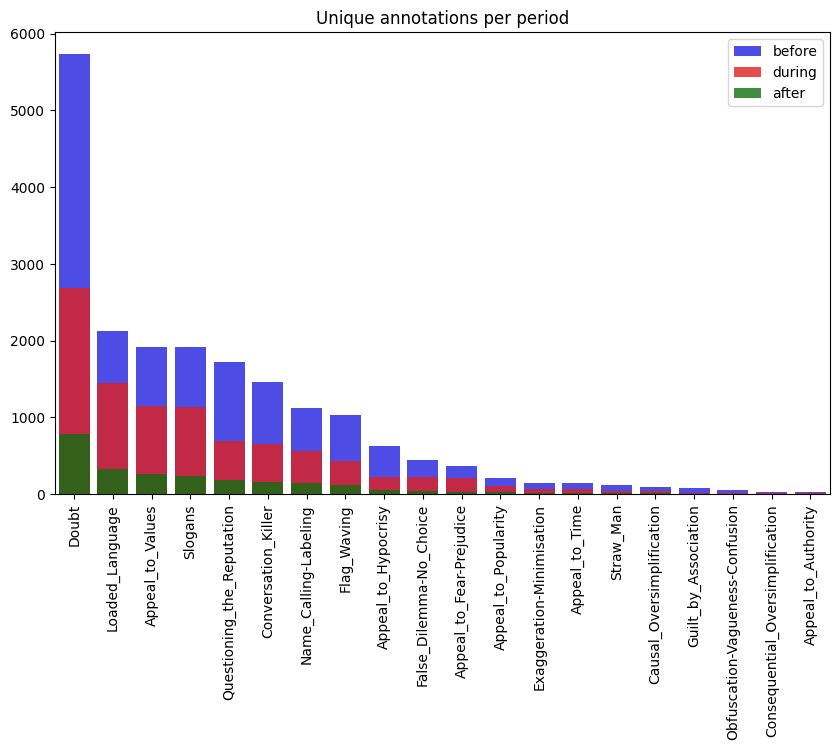

In [15]:
# plot annotations with dots
plt.figure(figsize=(10, 6))
# barplot
sns.barplot(x=before_annotations.index, y=before_annotations.values, color='blue', label='before', alpha=0.8)
sns.barplot(x=during_annotations.index, y=during_annotations.values, color='red', label='during', alpha=0.8)
sns.barplot(x=after_annotations.index, y=after_annotations.values, color='green', label='after', alpha=0.8)
plt.title('Unique annotations per period')

# legend and labels
plt.legend();
plt.xticks(rotation=90)

# Technique by party

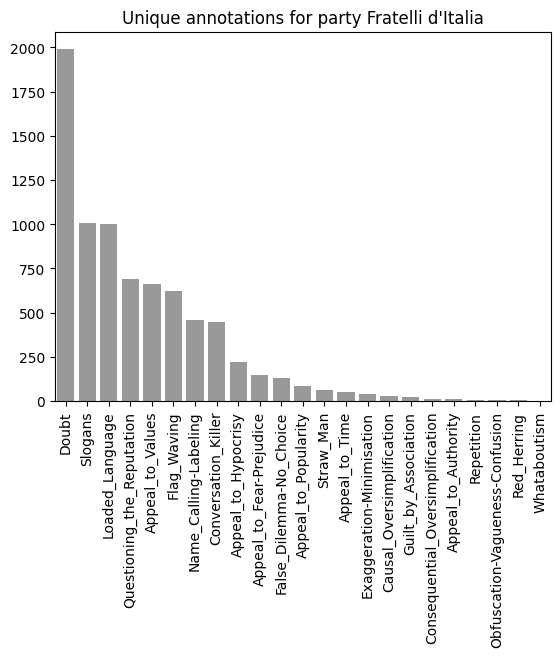

Doubt                         1990
Slogans                       1005
Loaded_Language               1003
Questioning_the_Reputation     690
Appeal_to_Values               662
Name: unique_annotations, dtype: int64


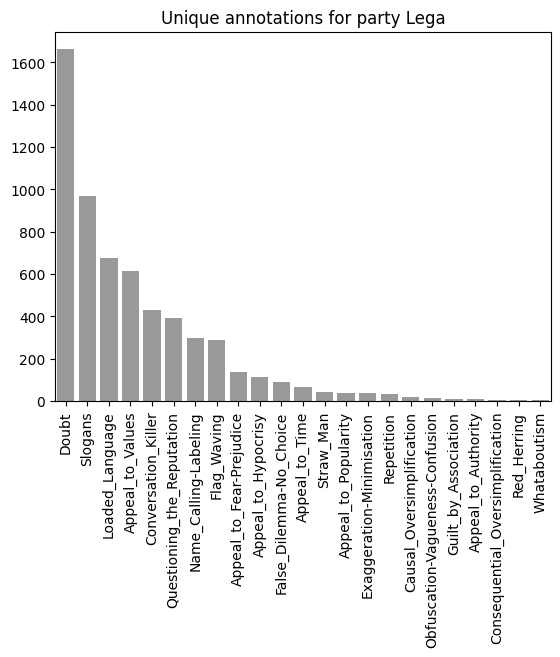

Doubt                  1663
Slogans                 969
Loaded_Language         675
Appeal_to_Values        617
Conversation_Killer     431
Name: unique_annotations, dtype: int64


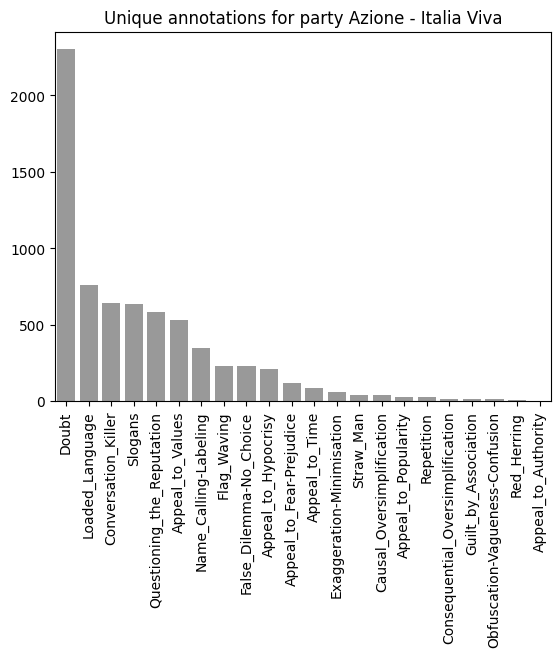

Doubt                         2302
Loaded_Language                757
Conversation_Killer            642
Slogans                        637
Questioning_the_Reputation     584
Name: unique_annotations, dtype: int64


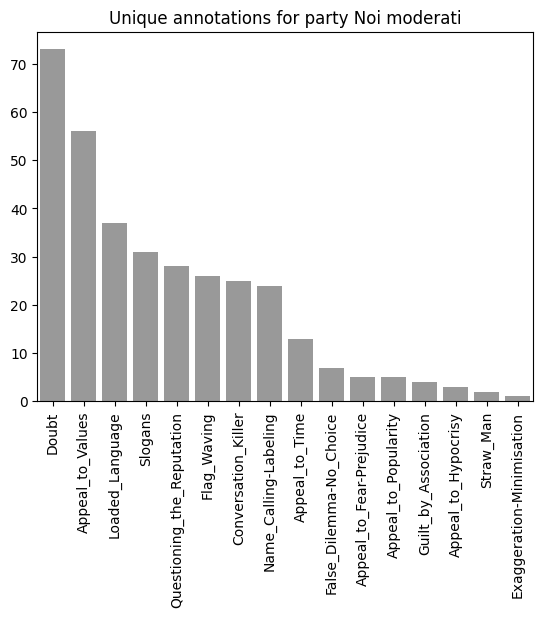

Doubt                         73
Appeal_to_Values              56
Loaded_Language               37
Slogans                       31
Questioning_the_Reputation    28
Name: unique_annotations, dtype: int64


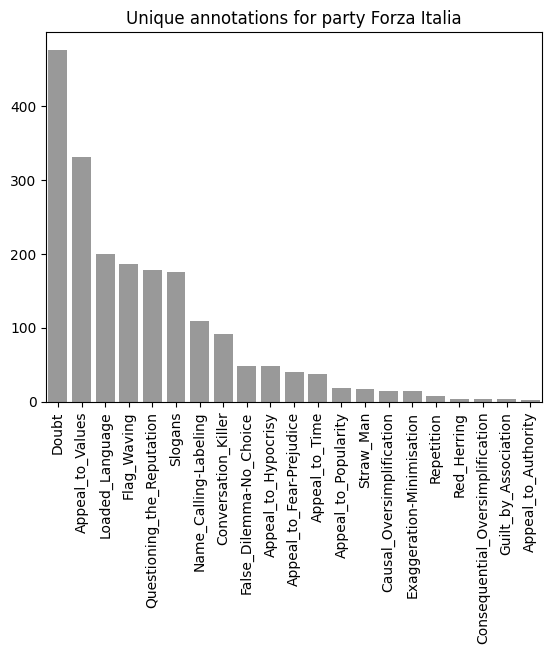

Doubt                         476
Appeal_to_Values              331
Loaded_Language               200
Flag_Waving                   186
Questioning_the_Reputation    178
Name: unique_annotations, dtype: int64


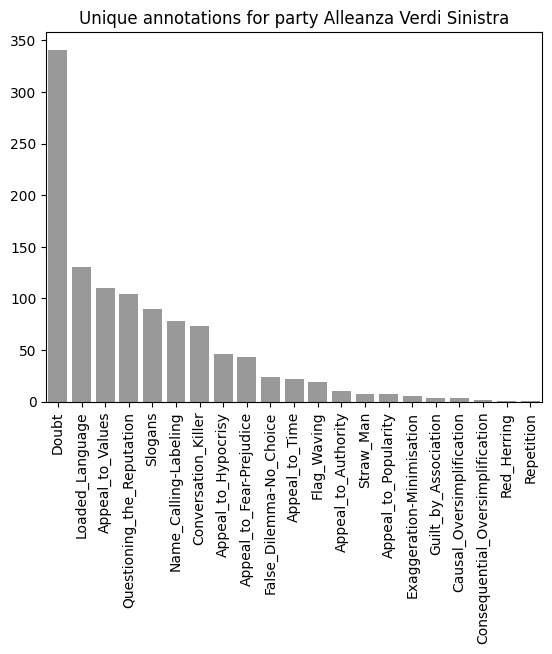

Doubt                         341
Loaded_Language               130
Appeal_to_Values              110
Questioning_the_Reputation    104
Slogans                        90
Name: unique_annotations, dtype: int64


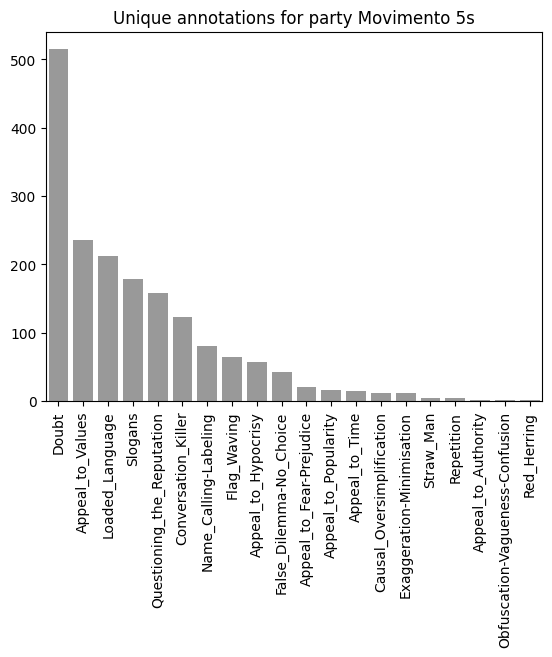

Doubt                         515
Appeal_to_Values              236
Loaded_Language               213
Slogans                       179
Questioning_the_Reputation    158
Name: unique_annotations, dtype: int64


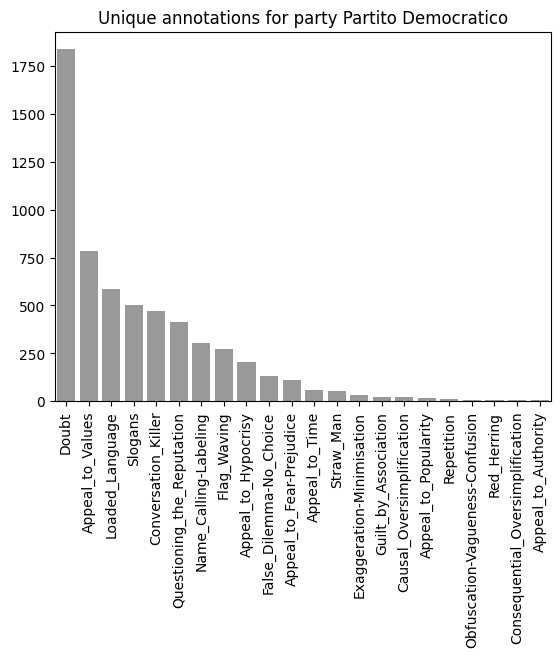

Doubt                  1839
Appeal_to_Values        786
Loaded_Language         586
Slogans                 503
Conversation_Killer     470
Name: unique_annotations, dtype: int64


In [16]:
for party in df["Party"].unique():
    party_annotations = df[df["Party"] == party]["unique_annotations"].explode().value_counts()
    # barplot
    sns.barplot(x=party_annotations.index, y=party_annotations.values, color="grey", alpha=0.8, label=party)
    plt.title('Unique annotations for party '+party)
    plt.xticks(rotation=90)
    plt.show()

    # print top 5 annotations for each party
    print(party_annotations.head(5))



# Techniques by party and period

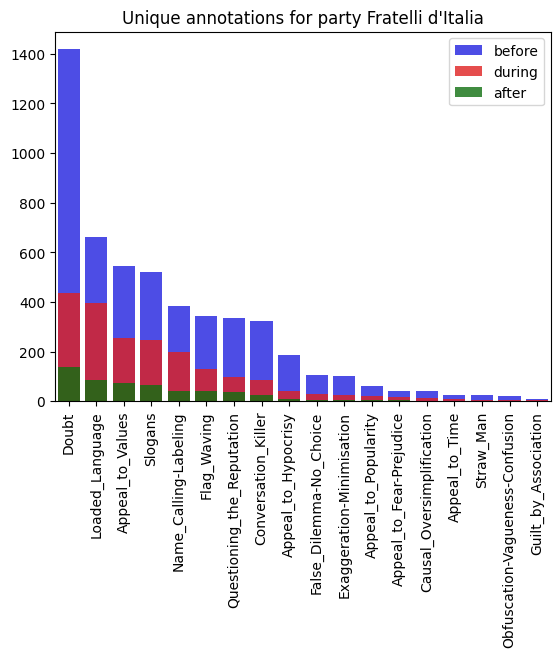

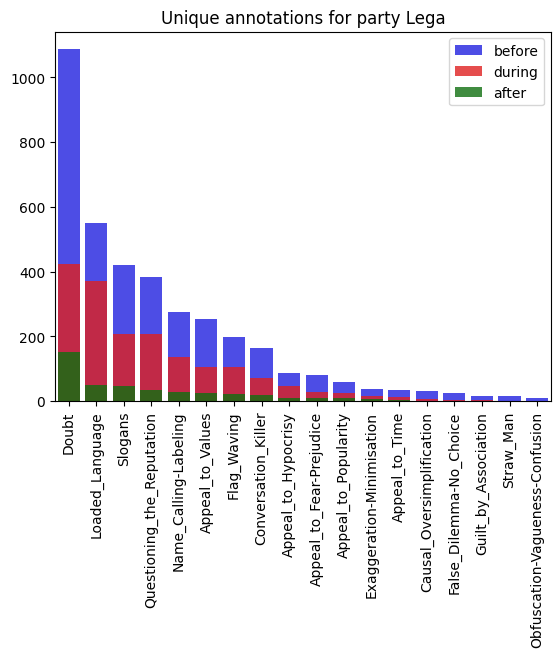

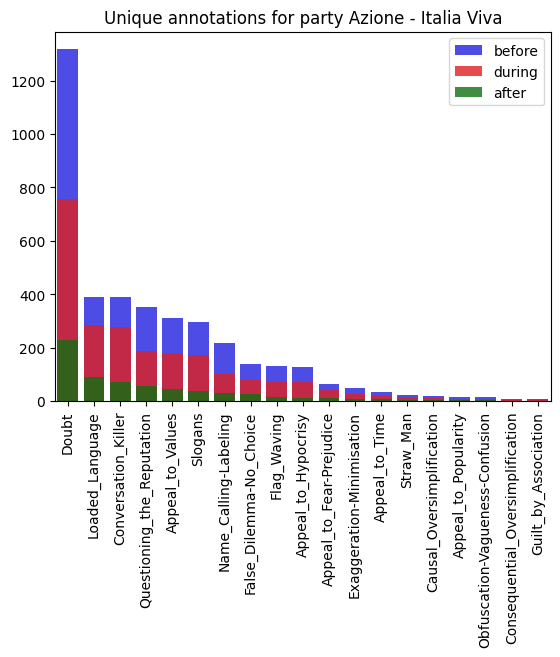

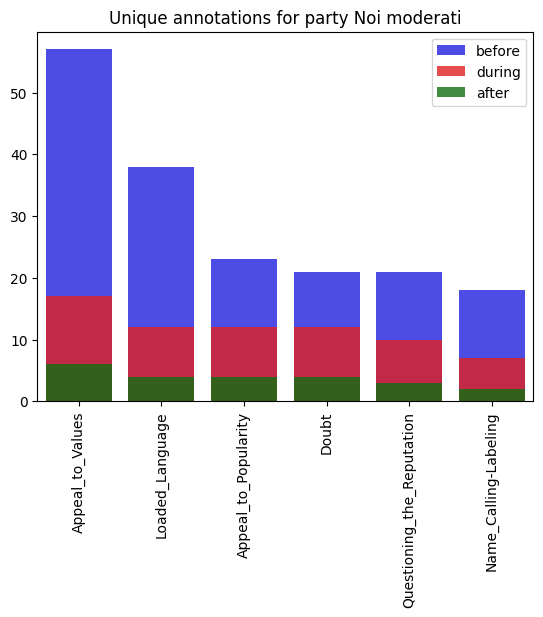

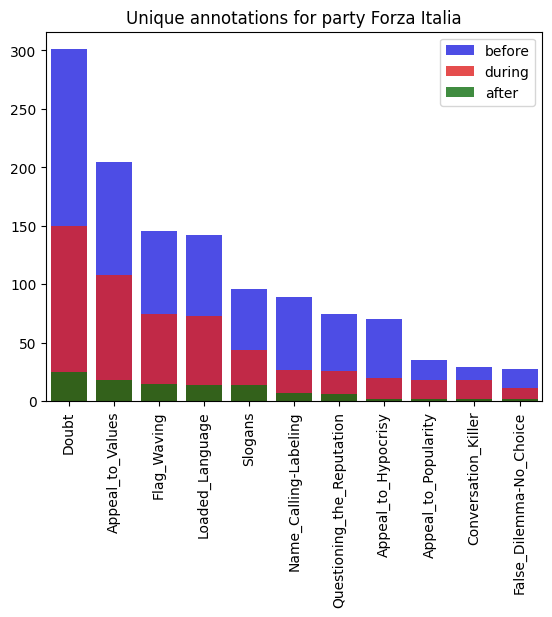

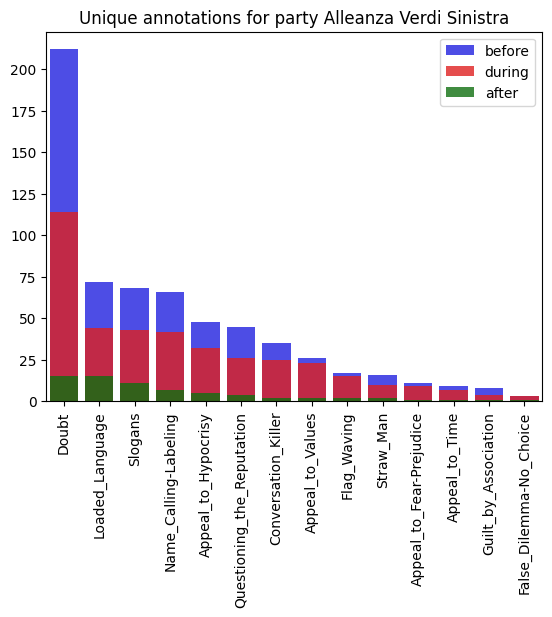

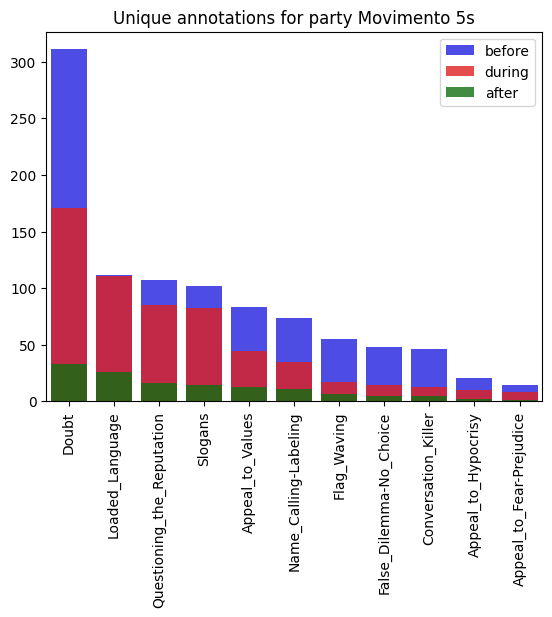

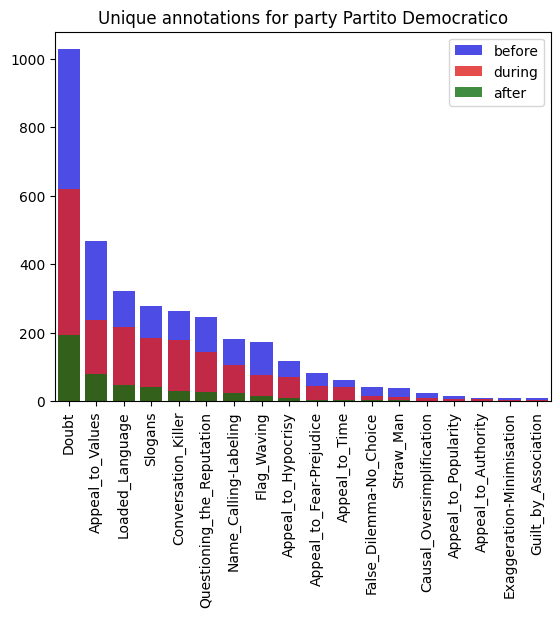

In [17]:
for party in df["Party"].unique():
    # before
    party_annotations_before = before[before["Party"] == party]["unique_annotations"].explode().value_counts()
    # during
    party_annotations_during = during[during["Party"] == party]["unique_annotations"].explode().value_counts()
    # after
    party_annotations_after = after[after["Party"] == party]["unique_annotations"].explode().value_counts()


    # barplots
    sns.barplot(x=party_annotations_before.index, y=party_annotations_before.values, color='blue', label='before', alpha=0.8)
    sns.barplot(x=party_annotations_during.index, y=party_annotations_during.values, color='red', label='during', alpha=0.8)
    sns.barplot(x=party_annotations_after.index, y=party_annotations_after.values, color='green', label='after', alpha=0.8)

    plt.title('Unique annotations for party '+party)
    plt.legend();
    plt.xticks(rotation=90)
    plt.show()